In [2]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler

In [3]:
# Check if Cuda is available, training takes ~15 Minutes with Cuda, no idea how long it would take with CPU
torch.cuda.is_available()

True

In [4]:
# Some Helper Methods

# Image Preprocess Method
def preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")

    # Define preprocessing transformations
    preprocess = transforms.Compose([
        transforms.Resize((244, 244)),  # Resize to 244x244
        transforms.ToTensor(),          # Convert to tensor (scales to [0, 1])
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for ResNet50
    ])

    img_tensor = preprocess(img)  # Apply transformations
    img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension
    return img_tensor


# Define DataLoader
def collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images)  # Stack images into a batch tensor
    labels = torch.stack(labels)  # Stack labels into a batch tensor
    return images, labels

# Load images and labels into batches
def load_data(image_paths, labels, batch_size):
    data_loader = []
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        batch_labels = labels[i:i+batch_size]
        
        batch_images = []
        for path in batch_paths:
            image = preprocess_image(path)  # Apply the preprocessing
            batch_images.append(image)
        
        batch_labels = torch.tensor(batch_labels)  # Convert labels to tensor
        data_loader.append((torch.stack(batch_images), batch_labels))
    
    return data_loader


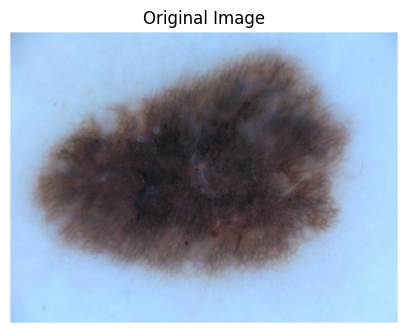

In [5]:
# Original Example Image

image_path = "E:\\melanoma_model\\ISIC_2019_Training_Input\\ISIC_0000000.jpg"

# Open and display the original image
img = Image.open(image_path).convert("RGB")
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")
plt.show()

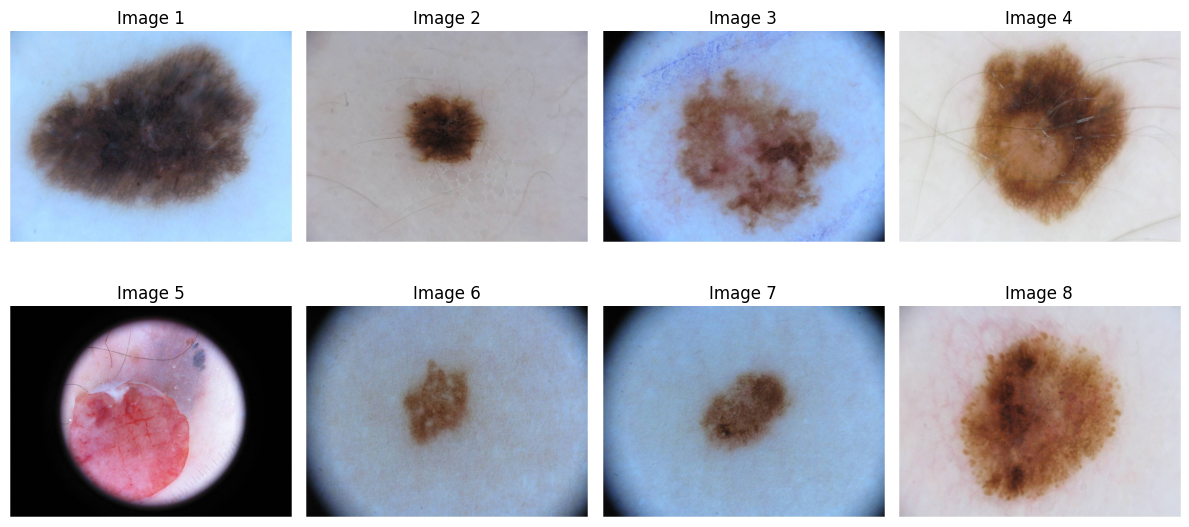

In [6]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Define the folder containing images
image_folder = "E:\\melanoma_model\\ISIC_2019_Training_Input"

# Get a list of image files and sort them
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith(".jpg")])

# Select the first 8 images
num_images = min(8, len(image_files))
selected_images = image_files[:num_images]

# Set up the plot
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Loop through the images and display them
for i, ax in enumerate(axes.flat):
    img_path = os.path.join(image_folder, selected_images[i])
    img = Image.open(img_path).convert("RGB")
    ax.imshow(img)
    ax.set_title(f"Image {i+1}")
    ax.axis("off")

plt.tight_layout()
plt.show()

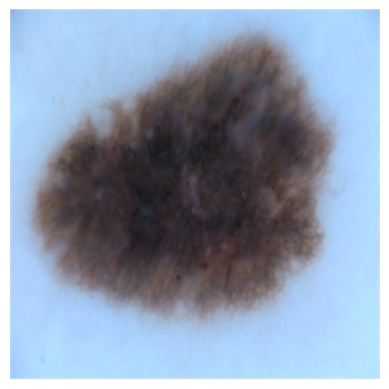

In [7]:
# Preprocessed Example Image

image_path = "E:\\melanoma_model\\ISIC_2019_Training_Input\\ISIC_0000000.jpg"
img_tensor = preprocess_image(image_path)


def show_image(tensor):
    # Remove batch dimension
    img = tensor.squeeze(0)

    # Reverse normalization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img * std + mean  # Unnormalize

    # Convert to NumPy and transpose channels
    img = img.numpy().transpose(1, 2, 0)

    # Display image
    plt.imshow(img)
    plt.axis("off")  # Hide axes
    plt.show()

show_image(img_tensor)

In [8]:

metadata_file = "C:\\Users\\gabri\\OneDrive\\Studium\\kurse\\6_Semester\\dshealth\\MelanomaClassification\\ISIC_2019_Training_Metadata.csv"
metadata = pd.read_csv(metadata_file)

# Handle missing values (impute missing with 'unknown' for categorical and mean for numerical)
metadata['age_approx'] = SimpleImputer(strategy='mean').fit_transform(metadata[['age_approx']])

# For categorical variables (anatom_site_general and sex), use label encoding or one-hot encoding
# Label encoding for 'sex' and 'anatom_site_general'
metadata['sex'] = LabelEncoder().fit_transform(metadata['sex'].astype(str))
metadata['anatom_site_general'] = LabelEncoder().fit_transform(metadata['anatom_site_general'].astype(str))

# Check for any missing values
metadata.isnull().sum()

# Scaling the numerical columns (e.g., 'age_approx')
scaler = StandardScaler()
metadata['age_approx'] = scaler.fit_transform(metadata[['age_approx']])

# Ensure the image ids match
image_ids = metadata['image'].values 

In [10]:
csv_file = "C:\\Users\\gabri\\OneDrive\\Studium\\kurse\\6_Semester\\dshealth\\MelanomaClassification\\ISIC_2019_Training_GroundTruth.csv"
data = pd.read_csv(csv_file)

# Find Paths to each image
image_paths = [os.path.join(image_folder, f"{img_id}.jpg") for img_id in data.iloc[:, 0]]
#image_paths = [os.path.join('archive/all', f'{img_id}.jpg') for img_id in data.iloc[:, 0]]
disease_columns = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']
labels = data[disease_columns].values.argmax(axis=1)


#train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)
from sklearn.model_selection import StratifiedShuffleSplit

# Stratified Split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in split.split(image_paths, labels):
    train_image_paths = [image_paths[i] for i in train_idx]
    test_image_paths = [image_paths[i] for i in test_idx]
    train_labels = labels[train_idx]
    test_labels = labels[test_idx]

print(torch.unique(torch.tensor(labels)))

tensor([0, 1, 2, 3, 4, 5, 6, 7])


In [11]:
# Define the batch size and DataLoader
batch_size = 32
dataset_size = len(image_paths)

In [12]:
# Load training and testing data
train_loader = load_data(train_image_paths, train_labels, batch_size)
test_loader = load_data(test_image_paths, test_labels, batch_size)

In [13]:
model = models.resnet101(pretrained=True)

for param in model.parameters():
    param.requires_grad = False  # Freeze all layers first

for param in model.layer3.parameters():
    param.requires_grad = True

for param in model.layer4.parameters():
    param.requires_grad = True

# Define a new classifier head with additional layers
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 9) 
)

# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

c:\Users\gabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
print(labels.min(), labels.max())
print(torch.unique(torch.tensor(labels)))


0 7
tensor([0, 1, 2, 3, 4, 5, 6, 7])


In [15]:
os_weight = torch.tensor([10.0]).to(device)

unique_labels = torch.unique(torch.tensor(labels))
print("Unique labels:", unique_labels)
print("Min label:", labels.min())
print("Max label:", labels.max())
print("Label dtype:", type(labels[0]))


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        #inputs, labels = inputs.to(device), torch.tensor(labels, dtype=torch.long).to(device)
        optimizer.zero_grad()  # Zero the gradients
        
        if inputs.dim() == 5:  # In case there's an extra dimension due to stacking
            inputs = inputs.squeeze(1)  # Remove the extra dimension

        outputs = model(inputs)  # Forward pass
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        loss.backward()  # Backward pass
        optimizer.step()  # Update parameters
        
        running_loss += loss.item()  # Accumulate loss
        
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Save the trained model
torch.save(model.state_dict(), "resnet50_skin_cancer_model.pth")

Unique labels: tensor([0, 1, 2, 3, 4, 5, 6, 7])
Min label: 0
Max label: 7
Label dtype: <class 'numpy.int64'>
Epoch [1/10], Loss: 0.9508
Epoch [2/10], Loss: 0.5807
Epoch [3/10], Loss: 0.3219
Epoch [4/10], Loss: 0.1990
Epoch [5/10], Loss: 0.1333
Epoch [6/10], Loss: 0.0943
Epoch [7/10], Loss: 0.0692
Epoch [8/10], Loss: 0.0675
Epoch [9/10], Loss: 0.0569
Epoch [10/10], Loss: 0.0519


Test Accuracy: 0.7938
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.62      0.68       904
           1       0.89      0.90      0.89      2575
           2       0.83      0.79      0.81       665
           3       0.43      0.61      0.50       173
           4       0.65      0.69      0.67       525
           5       0.69      0.56      0.62        48
           6       0.86      0.84      0.85        51
           7       0.43      0.64      0.52       126

    accuracy                           0.79      5067
   macro avg       0.69      0.71      0.69      5067
weighted avg       0.80      0.79      0.80      5067



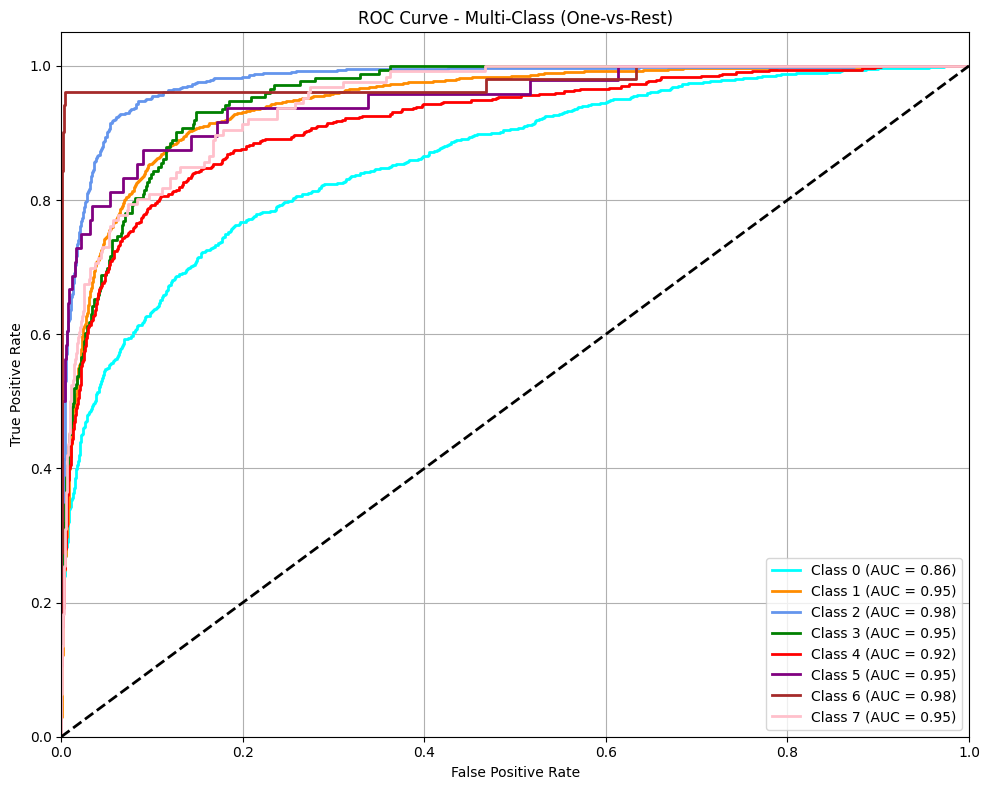

In [17]:
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

model.eval()
y_true = []
y_pred = []
y_scores = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        if inputs.dim() == 5:
            inputs = inputs.squeeze(1)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_scores.extend(outputs.cpu().numpy())  # Save raw output (logits or probs)

# Print metrics
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_true, y_pred, labels=list(range(8)), target_names=[str(i) for i in range(8)]))

# ==== ROC CURVE (One-vs-Rest) ====
y_true_bin = label_binarize(y_true, classes=list(range(8)))  # One-hot encode
y_scores = np.array(y_scores)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 8

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray'])
plt.figure(figsize=(10, 8))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multi-Class (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
